In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 95.1 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D,
    Input, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import faiss

2026-01-05 14:23:23.830307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767623004.012470      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767623004.064520      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767623004.493103      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767623004.493155      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767623004.493159      55 computation_placer.cc:177] computation placer alr

In [4]:
DATA_DIR = "/kaggle/input/fashion-product-images-small"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
CSV_PATH = os.path.join(DATA_DIR, "styles.csv")

df = pd.read_csv(CSV_PATH, on_bad_lines="skip")
df = df[["id", "articleType"]]
df["image_path"] = df["id"].apply(
    lambda x: os.path.join(IMAGE_DIR, f"{x}.jpg")
)
df = df[df["image_path"].apply(os.path.exists)]
df.reset_index(drop=True, inplace=True)

print("Total images:", len(df))

Total images: 44419


In [5]:
# 3. IMAGE PREPROCESSING


def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img.astype("float32")

In [6]:
# 4. TRIPLET GENERATION (IMPROVED)
def generate_triplet():
    anchor = df.sample(1).iloc[0]

    positive = df[
        df["articleType"] == anchor["articleType"]
    ].sample(1).iloc[0]

    negative = df[
        df["articleType"] != anchor["articleType"]
    ].sample(1).iloc[0]

    return (
        preprocess_image(anchor["image_path"]),
        preprocess_image(positive["image_path"]),
        preprocess_image(negative["image_path"])
    )


def triplet_generator():
    while True:
        a, p, n = generate_triplet()
        yield (a, p, n), np.zeros((1,), dtype="float32")

In [7]:
# 5. EMBEDDING MODEL
def create_embedding_model():
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Fine-tune last block
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dense(256)(x)
    output = Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    return Model(base_model.input, output)


embedding_model = create_embedding_model()

I0000 00:00:1767623062.382068      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [8]:
# 6. TRIPLET NETWORK
anchor_input = Input((224, 224, 3))
positive_input = Input((224, 224, 3))
negative_input = Input((224, 224, 3))

anchor_emb = embedding_model(anchor_input)
positive_emb = embedding_model(positive_input)
negative_emb = embedding_model(negative_input)

merged_output = Concatenate(axis=1)(
    [anchor_emb, positive_emb, negative_emb]
)

model = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=merged_output
)



In [9]:
# 7. TRIPLET LOSS

def triplet_loss(margin=0.3):
    def loss(y_true, y_pred):
        a = y_pred[:, 0:256]
        p = y_pred[:, 256:512]
        n = y_pred[:, 512:768]

        pos_dist = K.sum(K.square(a - p), axis=1)
        neg_dist = K.sum(K.square(a - n), axis=1)

        return K.mean(K.maximum(pos_dist - neg_dist + margin, 0))
    return loss


In [10]:
# ===============================
# 8. DATA PIPELINE
# ===============================

output_signature = (
    (
        tf.TensorSpec((224,224,3), tf.float32),
        tf.TensorSpec((224,224,3), tf.float32),
        tf.TensorSpec((224,224,3), tf.float32),
    ),
    tf.TensorSpec((1,), tf.float32)
)

train_ds = tf.data.Dataset.from_generator(
    triplet_generator,
    output_signature=output_signature
)

train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [11]:
# ===============================
# 9. TRAIN MODEL
# ===============================

model.compile(
    optimizer=Adam(1e-5),
    loss=triplet_loss()
)

model.fit(
    train_ds,
    steps_per_epoch=200,
    epochs=40
)

Epoch 1/40


I0000 00:00:1767623094.423958     126 service.cc:152] XLA service 0x7bf8b0117540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767623094.423995     126 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767623100.578334     126 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/200 ━━━━━━━━━━━━━━━━━━━━ 2:09:37 39s/step - loss: 0.2596

I0000 00:00:1767623110.442959     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 171s 662ms/step - loss: 0.1118
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 588ms/step - loss: 0.0783
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 109s 546ms/step - loss: 0.0673
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 101s 507ms/step - loss: 0.0617
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 98s 491ms/step - loss: 0.0572
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 88s 440ms/step - loss: 0.0484
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - loss: 0.0482
Epoch 8/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 80s 400ms/step - loss: 0.0525
Epoch 9/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 374ms/step - loss: 0.0501
Epoch 10/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 72s 361ms/step - loss: 0.0389
Epoch 11/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 357ms/step - loss: 0.0423
Epoch 12/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 347ms/step - loss: 0.0500
Epoch 13/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 71s 357ms/step - loss: 0.0433
Epoch 14/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - loss: 0.0400
Epoch 15/40
200/200 ━━

In [12]:
# ===============================
# 10. GENERATE EMBEDDINGS
# ===============================

embeddings = []
image_paths = []

for path in df["image_path"][:3000]:
    img = preprocess_image(path)
    emb = embedding_model.predict(
        np.expand_dims(img, axis=0),
        verbose=0
    )
    embeddings.append(emb[0])
    image_paths.append(path)

embeddings = np.array(embeddings).astype("float32")


In [13]:
# 11. FAISS INDEX

dimension = embeddings.shape[1]

quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, 100)

index.train(embeddings)
index.add(embeddings)

print("FAISS index size:", index.ntotal)

FAISS index size: 3000


WARNING clustering 3000 points to 100 centroids: please provide at least 3900 training points


In [14]:
# 12. COLOR HISTOGRAM (RE-RANKING)
# ===============================

def color_hist(img):
    hsv = cv2.cvtColor(
        (img * 255).astype(np.uint8),
        cv2.COLOR_RGB2HSV
    )
    hist = cv2.calcHist(
        [hsv], [0, 1], None,
        [50, 60], [0, 180, 0, 256]
    )
    return cv2.normalize(hist, hist).flatten()

In [15]:
# 13. SIMILARITY SEARCH
# ===============================

def find_similar(image_path, k=5):
    img = preprocess_image(image_path)
    emb = embedding_model.predict(
        np.expand_dims(img, axis=0),
        verbose=0
    ).astype("float32")

    distances, indices = index.search(emb, k * 3)

    query_hist = color_hist(img)
    scored = []

    for idx in indices[0]:
        candidate_img = preprocess_image(image_paths[idx])
        cand_hist = color_hist(candidate_img)
        color_dist = np.linalg.norm(query_hist - cand_hist)
        scored.append((image_paths[idx], color_dist))

    scored = sorted(scored, key=lambda x: x[1])
    return [x[0] for x in scored[:k]]

In [16]:
# 14. PLOT RESULTS
# ===============================

def plot_results(query_image, results):
    images = [query_image] + results
    titles = ["Query Image"] + [
        f"Result {i+1}" for i in range(len(results))
    ]

    plt.figure(figsize=(15, 4))
    for i, (img_path, title) in enumerate(zip(images, titles)):
        img = preprocess_image(img_path)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

Query Image: /kaggle/input/fashion-product-images-small/images/15970.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/15970.jpg
/kaggle/input/fashion-product-images-small/images/12950.jpg
/kaggle/input/fashion-product-images-small/images/12190.jpg
/kaggle/input/fashion-product-images-small/images/8186.jpg
/kaggle/input/fashion-product-images-small/images/15983.jpg


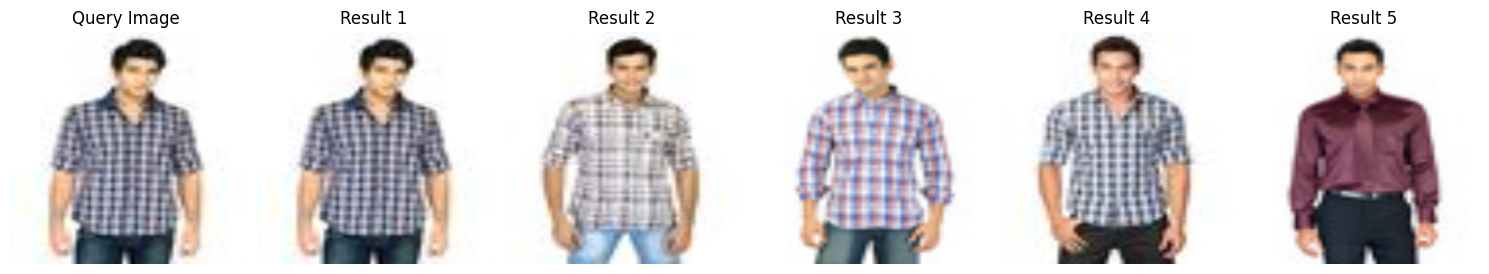

In [17]:
# 15. RUN DEMO
# ===============================

query_image = df.iloc[0]["image_path"]
results = find_similar(query_image, k=5)

print("Query Image:", query_image)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image, results)

In [33]:
import random

query_image_path = random.choice(image_paths)
print("Random Query Image:", query_image_path)

Random Query Image: /kaggle/input/fashion-product-images-small/images/7953.jpg


Query Image: /kaggle/input/fashion-product-images-small/images/7953.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/7953.jpg
/kaggle/input/fashion-product-images-small/images/43598.jpg
/kaggle/input/fashion-product-images-small/images/53795.jpg
/kaggle/input/fashion-product-images-small/images/34406.jpg
/kaggle/input/fashion-product-images-small/images/18638.jpg


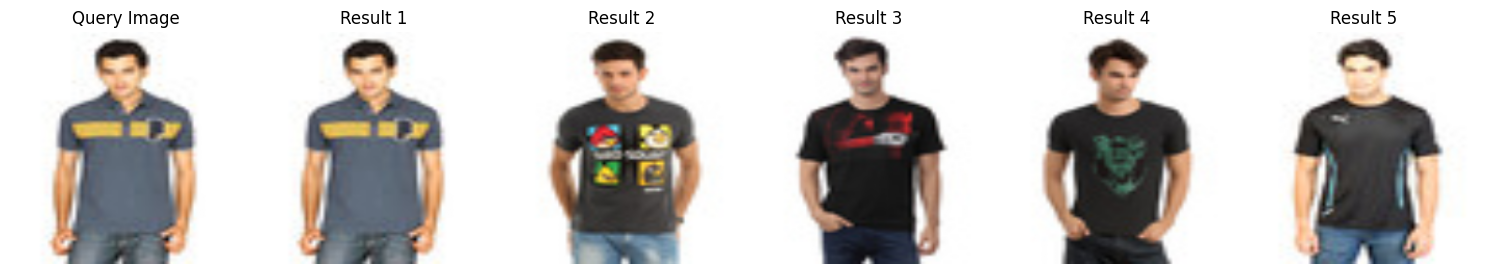

In [34]:
# 15. RUN DEMO
# ===============================

#query_image = df.iloc[0]["image_path"]
results = find_similar(query_image_path, k=5)

print("Query Image:", query_image_path)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image_path, results)

In [20]:
import random

query_image_path = random.choice(image_paths)
print("Random Query Image:", query_image_path)

Random Query Image: /kaggle/input/fashion-product-images-small/images/22357.jpg


Query Image: /kaggle/input/fashion-product-images-small/images/22357.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/22357.jpg
/kaggle/input/fashion-product-images-small/images/17285.jpg
/kaggle/input/fashion-product-images-small/images/37812.jpg
/kaggle/input/fashion-product-images-small/images/7930.jpg
/kaggle/input/fashion-product-images-small/images/28853.jpg


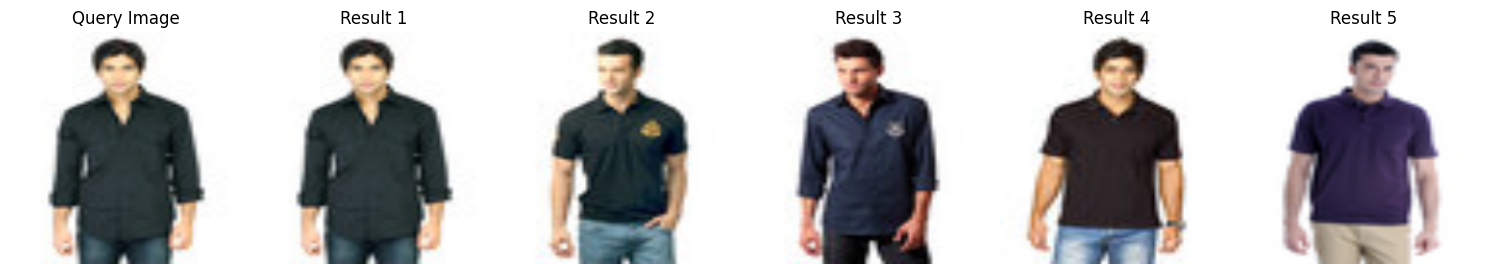

In [21]:
# 15. RUN DEMO
# ===============================

#query_image = df.iloc[0]["image_path"]
results = find_similar(query_image_path, k=5)

print("Query Image:", query_image_path)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image_path, results)

In [22]:
import random

query_image_path = random.choice(image_paths)
print("Random Query Image:", query_image_path)

Random Query Image: /kaggle/input/fashion-product-images-small/images/44970.jpg


Query Image: /kaggle/input/fashion-product-images-small/images/44970.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/44970.jpg
/kaggle/input/fashion-product-images-small/images/25322.jpg
/kaggle/input/fashion-product-images-small/images/22950.jpg
/kaggle/input/fashion-product-images-small/images/43164.jpg
/kaggle/input/fashion-product-images-small/images/43163.jpg


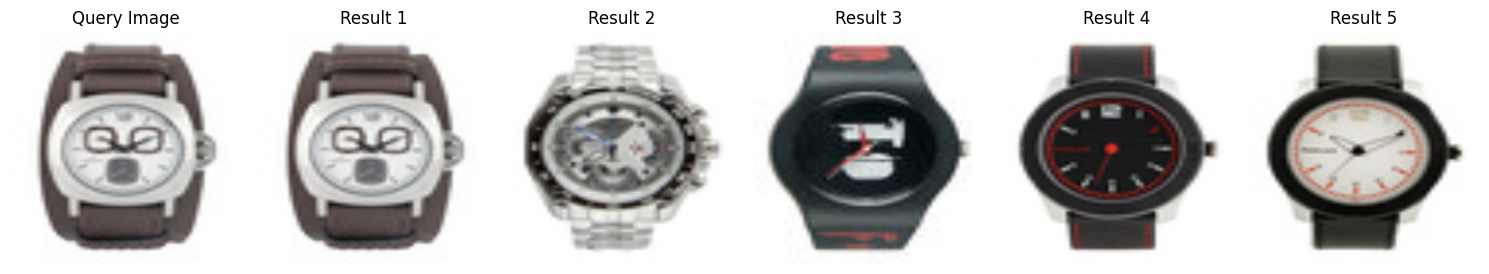

In [23]:
# 15. RUN DEMO
# ===============================

#query_image = df.iloc[0]["image_path"]
results = find_similar(query_image_path, k=5)

print("Query Image:", query_image_path)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image_path, results)

In [57]:
import random

query_image_path = random.choice(image_paths)
print("Random Query Image:", query_image_path)

Random Query Image: /kaggle/input/fashion-product-images-small/images/21948.jpg


Query Image: /kaggle/input/fashion-product-images-small/images/21948.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/21948.jpg
/kaggle/input/fashion-product-images-small/images/25175.jpg
/kaggle/input/fashion-product-images-small/images/16767.jpg
/kaggle/input/fashion-product-images-small/images/52622.jpg
/kaggle/input/fashion-product-images-small/images/20498.jpg


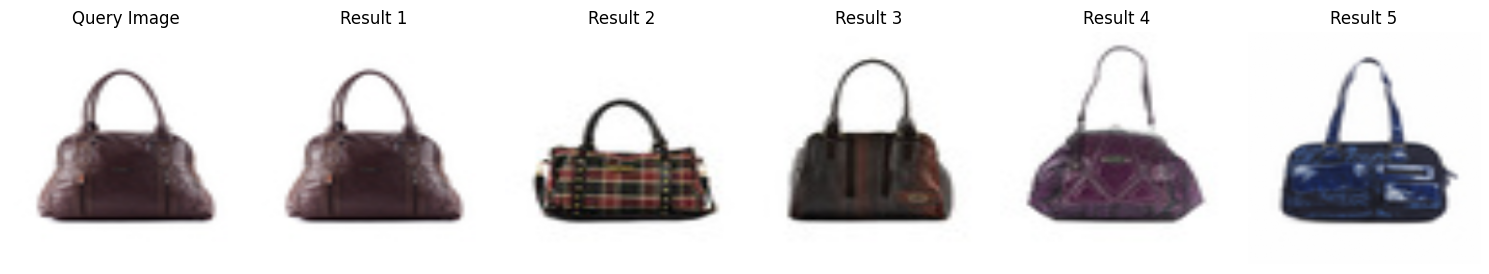

In [58]:
# 15. RUN DEMO
# ===============================

#query_image = df.iloc[0]["image_path"]
results = find_similar(query_image_path, k=5)

print("Query Image:", query_image_path)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image_path, results)

In [41]:
import random

query_image_path = random.choice(image_paths)
print("Random Query Image:", query_image_path)

Random Query Image: /kaggle/input/fashion-product-images-small/images/9455.jpg


Query Image: /kaggle/input/fashion-product-images-small/images/9455.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/9455.jpg
/kaggle/input/fashion-product-images-small/images/9261.jpg
/kaggle/input/fashion-product-images-small/images/19719.jpg
/kaggle/input/fashion-product-images-small/images/15915.jpg
/kaggle/input/fashion-product-images-small/images/33240.jpg


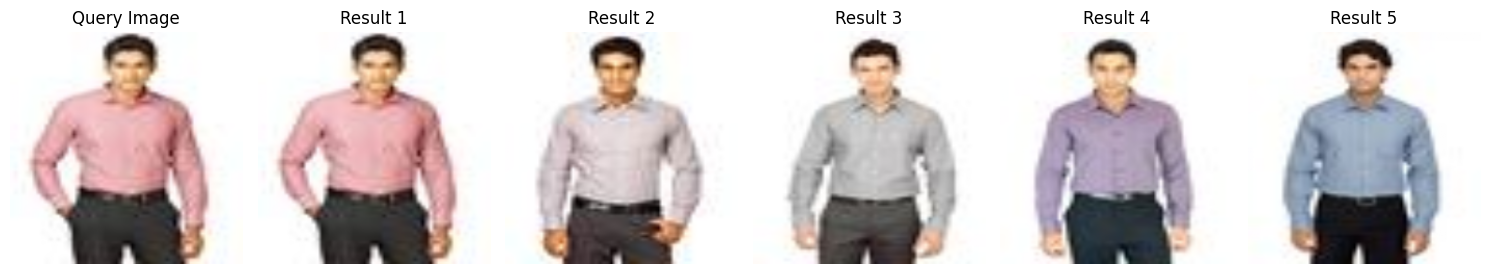

In [42]:
# 15. RUN DEMO
# ===============================

#query_image = df.iloc[0]["image_path"]
results = find_similar(query_image_path, k=5)

print("Query Image:", query_image_path)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image_path, results)

In [43]:
# Save embedding model
embedding_model.save("embedding_model.h5")

# Save embeddings and image paths
np.save("embeddings.npy", embeddings)
np.save("image_paths.npy", np.array(image_paths))

# Save FAISS index
faiss.write_index(index, "faiss.index")

Query Image: /kaggle/input/fashion-product-images-small/images/34406.jpg
Similar Images:
/kaggle/input/fashion-product-images-small/images/34406.jpg
/kaggle/input/fashion-product-images-small/images/43598.jpg
/kaggle/input/fashion-product-images-small/images/53795.jpg
/kaggle/input/fashion-product-images-small/images/6229.jpg
/kaggle/input/fashion-product-images-small/images/20258.jpg


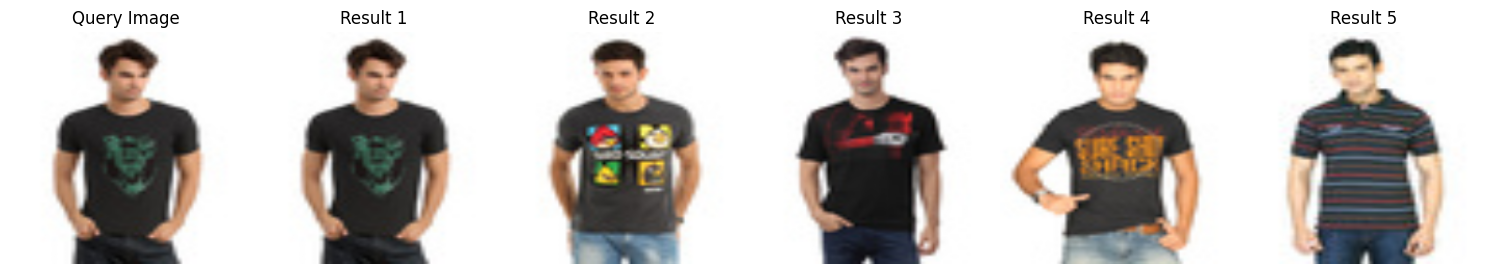

In [64]:
# 15. RUN DEMO
# ===============================

query_image = "/kaggle/input/fashion-product-images-small/images/34406.jpg"
results = find_similar(query_image, k=5)

print("Query Image:", query_image)
print("Similar Images:")
for r in results:
    print(r)

plot_results(query_image, results)